## MEPS Dataset - Platform Data Scientist Homework

So we have two files - one with basic demographic info and one with medications. They're small and pandas will deal with them fine - no need for SQL in an offline analysis setting. We'll probably want to JOIN them on id to make predictions.

Some obvious stuff just from looking at them -  
1) a seemingly significant proportion of subjects are younger than sixteen. For these individuals, we have basically zero info - we might just want to drop them from our tables and not make predictions for them. A cursory search of meds reveals no medication info for them.  
2) we have tons of duplicate meds - we'll probably want to consolidate these

By the way, I've mostly hand-tested operations rather than using asserts or a proper test suite, but it's perfectly reasonable to test data science code even though the community doesn't value testing as highly as the broader CS community.

In [238]:
#python = 2.7.x, since I figure you probably use that, but I'll keep the code 3.x compatible where possible

import numpy as np
import pandas as pd
import xgboost as xgb

#for quick descriptive stats, I like to use a simple graphing library called Seaborn that's build on top of matplotlib.
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score


pd.options.display.max_columns = 50
sns.set_palette('pastel')


subjects = pd.read_csv("../input/meps_base_data.csv")
meds = pd.read_csv("../input/meps_meds.csv")


def display_summary(dfs_to_describe, preview_size=5):
    print("\n\n Summary of data: \n\n")
    
    for df in dfs_to_describe:

        print("First 5 rows: ")
        print(df.head(preview_size))
        print("\n\n Stats: ")
        print(df.describe())
        print("\n\n")

    
display_summary([subjects,meds])



 Summary of data: 


First 5 rows: 
   Unnamed: 0        id  panel  pooledWeight  age     sex      race  \
0           1  10007101     15   3603.881236   28    Male     White   
1           2  10007102     15   2544.550424   25  Female     White   
2           3  10007103     15   4050.397468    4    Male     White   
3           4  10007104     15   3064.059720    3  Female     White   
4           5  10008101     15   3635.552466   51    Male  Multiple   

                   married highBPDiagnosed diabetesDiagnosed  chdDiagnosed  \
0                  MARRIED             Yes                No            No   
1                  MARRIED              No                No            No   
2  UNDER 16 - INAPPLICABLE    Inapplicable      Inapplicable  Inapplicable   
3  UNDER 16 - INAPPLICABLE    Inapplicable      Inapplicable  Inapplicable   
4                  MARRIED              No                No            No   

    miDiagnosed anginaDiagnosed strokeDiagnosed emphysemaDiagnosed

### Data Cleanup  

Let's think about what data we can drop -  

1) from our subjects,  
    a) "panel" seems to be panel year and is unlikely to be terribly useful to us, at least for now.  
    b) "pooledWeight" seems to be used for a weighting function / to correct for demographics. I couldn't immediately find details on how to use the weighting function, so I'm ignoring it for now.  
    
2)  from our medications
    a) we have tons of duplicates of drugs - presumably we have one record per prescription written; let's just keep one record of a prescription of a given drug per person (we'll assume that they've stayed on it)  
    b) right now, let's drop a few columns - rxNDC is apparently a "NATIONAL DRUG CODE (IMPUTED)"; this might initially seem useful, but it actually isn't because there are multiple codes for many drugs    
    
Let's also drop rxStartMonth - we could use this and rxStartYear to build a more standardized datetime scheme (ignoring that months are missing very frequently), but for now let's just use year; year could be useful - lets us control for differing prescriptions used to treat diseases as medicine progresses.  


In [239]:
#simple try function so we can run drop statements multiple times without errors
def try_drop(df, cols):
    for col in cols:
        try:
            df.drop([col], axis=1, inplace=True)
        except ValueError:
            print("Drop failed on column (probably already dropped): " + str(col))

#drop fields mentioned above
try_drop(subjects,['Unnamed: 0', 'panel','pooledWeight'])
try_drop(meds,['Unnamed: 0', 'rxNDC','rxStartMonth'])

#drop individuals younger than 16
try: subjects.drop(subjects[subjects.age < 16].index, inplace=True)
except ValueError: print('Already dropped underage subjects.')

#impute mean prescription year for prescriptions with invalid years (e.g -8)  
valid_by_year = meds[meds.rxStartYear > 1900]
avg_rx_year = valid_by_year.rxStartYear.mean()
#apply that value to prescriptions with invalid years
meds.loc[meds.rxStartYear < 1900] = avg_rx_year

meds.drop_duplicates(subset = ['id','rxName'], inplace=True)

display_summary([subjects,meds])



 Summary of data: 


First 5 rows: 
         id  age     sex      race        married highBPDiagnosed  \
0  10007101   28    Male     White        MARRIED             Yes   
1  10007102   25  Female     White        MARRIED              No   
4  10008101   51    Male  Multiple        MARRIED              No   
5  10008102   53  Female     Asian        MARRIED              No   
7  10009101   61  Female     Black  NEVER MARRIED             Yes   

  diabetesDiagnosed chdDiagnosed miDiagnosed anginaDiagnosed strokeDiagnosed  \
0                No           No          No              No              No   
1                No           No          No              No              No   
4                No           No          No              No              No   
5                No           No          No              No              No   
7                No           No          No              No              No   

  emphysemaDiagnosed asthmaDiagnosed otherHDDiagnosed heartFailure

#### JOIN

I'm going to inner join, so we keep all prescriptions for people who we have demographic info.  
It would also be reasonable to left join so that we keep info on all people even if they don't have any prescriptions. I went ahead and also tried a left join, and it only affected the number of subjects pretty marginally (by <10%).

In [240]:
subj_and_meds = pd.merge(subjects, meds, how='inner', on='id', sort=True)
#subj_and_meds = pd.merge(subjects, meds, how='left', on='id', sort=True)
print(subjects.columns.values)
print(meds.columns.values)
print(subj_and_meds.columns.values)
print(subj_and_meds.shape)
#display_summary([subj_and_meds])

['id' 'age' 'sex' 'race' 'married' 'highBPDiagnosed' 'diabetesDiagnosed'
 'chdDiagnosed' 'miDiagnosed' 'anginaDiagnosed' 'strokeDiagnosed'
 'emphysemaDiagnosed' 'asthmaDiagnosed' 'otherHDDiagnosed'
 'heartFailureDiagnosed']
['id' 'rxStartYear' 'rxName' 'rxQuantity' 'rxForm']
['id' 'age' 'sex' 'race' 'married' 'highBPDiagnosed' 'diabetesDiagnosed'
 'chdDiagnosed' 'miDiagnosed' 'anginaDiagnosed' 'strokeDiagnosed'
 'emphysemaDiagnosed' 'asthmaDiagnosed' 'otherHDDiagnosed'
 'heartFailureDiagnosed' 'rxStartYear' 'rxName' 'rxQuantity' 'rxForm']
(169868, 19)


In [241]:
# visually inspect result of JOIN to make sure it worked as expected
# subj_and_meds.to_csv("joined_data.csv")

### Variable Encoding  

We currently don't have much of our info in an easily-interpretable form for our model(s) - we'll want to re-encode a whole bunch of categorial variables -  

1) we need to turn our sex column and diagnoses into a boolean value - e.g. "isFemale"   
2) we need to one-hot encode race and married  
 

In [242]:
# let's start with re-encoding sex

try: subj_and_meds['isFemale'] = subj_and_meds.sex == "Female"
except AttributeError: print("isFemale already created. Skipping.")
try_drop(subj_and_meds, ['sex'])

# now let's re-encode all the diagnoses
# or == True so I can run this code multiple times without getting glitches
yn_to_bool = lambda value: value == "Yes" or value == True 
diagnoses = ['highBPDiagnosed', 'diabetesDiagnosed', 'chdDiagnosed', 'miDiagnosed', 'anginaDiagnosed',
             'strokeDiagnosed', 'emphysemaDiagnosed', 'asthmaDiagnosed', 'otherHDDiagnosed', 'heartFailureDiagnosed']
for diagnosis in diagnoses:
    subj_and_meds[diagnosis] = subj_and_meds[diagnosis].apply(yn_to_bool)
    
print("Cols incl. newly-created bools: ")
print(subj_and_meds.columns)

# for the sake of code cleanliness, I'll create both sets here, but you could argue that 
# I should create them separately to have more descriptive variable names (e.g. "race_"
# and "marital_" prefixes rather than "d_")
try: subj_and_meds = pd.get_dummies(subj_and_meds, columns = ['race', 'married'], prefix='d_')
except ValueError: print("Couldn't find dummy sources - likely already created.")
print("dummy cols: ")
print(subj_and_meds.columns)

#try_drop(subj_and_meds, diagnoses)
#subj_and_meds = pd.concat([subj_and_meds, dummies], axis=1)

print("\n\n Now including dummies: \n\n")
try_drop(subj_and_meds, ['race', 'married'])
print(subj_and_meds.columns)
print(subj_and_meds.head(3))

Cols incl. newly-created bools: 
Index([u'id', u'age', u'race', u'married', u'highBPDiagnosed',
       u'diabetesDiagnosed', u'chdDiagnosed', u'miDiagnosed',
       u'anginaDiagnosed', u'strokeDiagnosed', u'emphysemaDiagnosed',
       u'asthmaDiagnosed', u'otherHDDiagnosed', u'heartFailureDiagnosed',
       u'rxStartYear', u'rxName', u'rxQuantity', u'rxForm', u'isFemale'],
      dtype='object')
dummy cols: 
Index([u'id', u'age', u'highBPDiagnosed', u'diabetesDiagnosed',
       u'chdDiagnosed', u'miDiagnosed', u'anginaDiagnosed', u'strokeDiagnosed',
       u'emphysemaDiagnosed', u'asthmaDiagnosed', u'otherHDDiagnosed',
       u'heartFailureDiagnosed', u'rxStartYear', u'rxName', u'rxQuantity',
       u'rxForm', u'isFemale', u'd__Amer Indian/Alaska Native', u'd__Asian',
       u'd__Black', u'd__Multiple', u'd__Native Hawaiian/Pacific Islander',
       u'd__White', u'd__DIVORCED', u'd__DIVORCED IN ROUND', u'd__MARRIED',
       u'd__MARRIED IN ROUND', u'd__NEVER MARRIED', u'd__SEPARATED',
 

In [243]:
# visually inspect result of concat above to make sure it worked as expected
# subj_and_meds.to_csv("with_dummies.csv")

I noticed that we have categories that we might want to merge - e.g. "widowed in round" is pretty rare and should, perhaps, be merged into "widowed."  
One other caveat - we have no default for our dummy variables, which will cause multicollinearity issues with regression models - we should fix this later if we want to use them.

## The part where I actually answer the questions you asked!

#### 1) What are the most common medications for each disease in the base file?

In [244]:
for diagnosis in diagnoses:
    current_diagnosis = subj_and_meds[subj_and_meds[diagnosis] == True]
    print("\n\n For diagnosis " + str(diagnosis) + ", most common prescription is \n\n")
    print(current_diagnosis['rxName'].describe())



 For diagnosis highBPDiagnosed, most common prescription is 


count          93623
unique          5650
top       LISINOPRIL
freq            2476
Name: rxName, dtype: object


 For diagnosis diabetesDiagnosed, most common prescription is 


count         40116
unique         3823
top       METFORMIN
freq           1158
Name: rxName, dtype: object


 For diagnosis chdDiagnosed, most common prescription is 


count          22039
unique          2867
top       LISINOPRIL
freq             466
Name: rxName, dtype: object


 For diagnosis miDiagnosed, most common prescription is 


count          14725
unique          2333
top       LISINOPRIL
freq             339
Name: rxName, dtype: object


 For diagnosis anginaDiagnosed, most common prescription is 


count          11603
unique          2164
top       LISINOPRIL
freq             194
Name: rxName, dtype: object


 For diagnosis strokeDiagnosed, most common prescription is 


count          14319
unique          2464
top       LISINOP

Gut check - lisinopril is an ACE inhibitor, and ACE inhibitors are a frontline treatment for hypertension. Metformin is a frontline treatment for type 2 diabetes (and type 2 is far more common than type 1).

#### 2) What medications are most indicative of each disease?

This one is a bit more complicated. You could just say it's the most common, but of course that's ignoring that some drugs are more commonly prescribed regardless of a person's diagnoses. What I think you're looking for is rather which drug is the most specific for each disease. So I'll calculate:

instances of drug for disease / instances of drug overall

In other words, I'm getting the precision of a given drug in making a diagnosis for a given disease.

One caveat: if we have drugs with exceedingly low counts - say one doctor has homeopathic leanings and prescribes a diabetic patient ginseng - it could seemingly be a perfect identifier by this metric. Instead, I'll only look at the drugs that are reasonably common - using exceedingly rare drugs to diagnoses common diseases seems like it would only be marginally useful, anyway. 

By the way, in the real world, there are metric we might prefer to precision (e.g. F1-score), but I'm using precision here in keeping with the way the question is formulated. 

In [245]:
"""drugs = subj_and_meds.rxName.unique()
print(drugs)"""

# we'll take our list of prescriptions, and get their counts
# all our most common drugs per diagnosis above have high frequencies (>1000), but I'll go ahead and grab the top 100
# use counts as the index, so we have them sorted by descending frequency
# apologies for this being close to functional spaghetti
drugs = ((subj_and_meds['rxName'].value_counts()).ix[0:100]).reset_index(drop=False)

#fix col names
drugs.rename(columns={'index': 'rxName', 'rxName': 'count'}, inplace=True)

# confirm size of list...
print(drugs.rxName.size)
#confirm that our most common drugs are here, indexed by count
print(drugs.ix[0:10])


100
                 rxName  count
0          AZITHROMYCIN   3358
1            LISINOPRIL   2865
2           AMOXICILLIN   2687
3           SIMVASTATIN   2312
4             IBUPROFEN   2243
5            PREDNISONE   1712
6          HYDROCO/APAP   1703
7               LIPITOR   1630
8            OMEPRAZOLE   1496
9             METFORMIN   1422
10  HYDROCHLOROTHIAZIDE   1281


In [246]:
drug_precisions = pd.DataFrame(columns=['rxName','diagnosis','precision'])

# just iterate through each dx and each drug - O(n^2)
# there's plenty of room to optimize this code if it gets run frequently :)
# (also, explicit looping with indexing is ugly)
index_ = 0
for drug in drugs.rxName:
    #get number of users for the drug
    users = float(subj_and_meds[subj_and_meds['rxName'] == drug]['rxName'].size)
    #checked that these counts are equal to the counts above - commented it out now
    for diagnosis in diagnoses:
        #get number of users of the drug who have the diagnosis
        users_with_dx = subj_and_meds[(
                subj_and_meds[diagnosis] == True) & (subj_and_meds['rxName'] == drug)]['rxName'].size
        this_precision = users_with_dx/users
        drug_precisions.loc[index_] = {'rxName':drug,'diagnosis':diagnosis , 'precision':this_precision}
        index_ += 1
        
print(drug_precisions.head(10))


         rxName              diagnosis  precision
0  AZITHROMYCIN        highBPDiagnosed   0.335616
1  AZITHROMYCIN      diabetesDiagnosed   0.097677
2  AZITHROMYCIN           chdDiagnosed   0.060453
3  AZITHROMYCIN            miDiagnosed   0.035736
4  AZITHROMYCIN        anginaDiagnosed   0.033949
5  AZITHROMYCIN        strokeDiagnosed   0.034544
6  AZITHROMYCIN     emphysemaDiagnosed   0.034544
7  AZITHROMYCIN        asthmaDiagnosed   0.147409
8  AZITHROMYCIN       otherHDDiagnosed   0.114652
9  AZITHROMYCIN  heartFailureDiagnosed   0.011912


In [247]:
precisions = pd.DataFrame(columns=['diagnosis','max_precision', 'rx_name'])

for i,diagnosis in enumerate(diagnoses):
    max_precision = drug_precisions[drug_precisions['diagnosis'] == diagnosis]['precision'].max()
    max_index = drug_precisions[drug_precisions['diagnosis'] == diagnosis]['precision'].idxmax()
    rx_name = drug_precisions.ix[max_index]['rxName']
    
    this_precision = {'diagnosis':diagnosis, 'max_precision':max_precision, 'rx_name':rx_name}
    precisions.loc[len(precisions)] = this_precision
    
    print("Maximal precision for diagnosising disease " + str(diagnosis) + " with drug " + str(
            rx_name) + "; precision = " + str(max_precision))
    
print("\n\n")
print(precisions)

Maximal precision for diagnosising disease highBPDiagnosed with drug DIOVAN HCT; precision = 0.970297029703
Maximal precision for diagnosising disease diabetesDiagnosed with drug ACTOS; precision = 0.965591397849
Maximal precision for diagnosising disease chdDiagnosed with drug PLAVIX; precision = 0.529126213592
Maximal precision for diagnosising disease miDiagnosed with drug PLAVIX; precision = 0.401294498382
Maximal precision for diagnosising disease anginaDiagnosed with drug PLAVIX; precision = 0.296116504854
Maximal precision for diagnosising disease strokeDiagnosed with drug PLAVIX; precision = 0.307443365696
Maximal precision for diagnosising disease emphysemaDiagnosed with drug ADVAIR DISKU; precision = 0.211038961039
Maximal precision for diagnosising disease asthmaDiagnosed with drug ADVAIR DISKU; precision = 0.675324675325
Maximal precision for diagnosising disease otherHDDiagnosed with drug WARFARIN; precision = 0.552631578947
Maximal precision for diagnosising disease heart

In [270]:
%matplotlib inline

formatted_dx = ['High BP, Diovan', 'Diabetes, Actos', 'CHD, Plavix', 'MI, Plavix',
                'Angina, Plavix', 'Stroke, Plavix', 'Emphysema, Advair', 'Asthma, Advair',
                'Other HD, Warfarin', 'Heart Failure, Carvedilol']

plt.figure(figsize=(18,5))
plt.title('Diagnostic Sensitivities')

ax = sns.barplot(x=precisions.diagnosis, y=precisions.max_precision, data=precisions)
ax.set_ylabel("Precision"); ax.set_xlabel("Diagnosis, Drug")
ax.set_xticklabels(formatted_dx)

plt.show()

Gut check - these make sense - Diovan HCT is a combo ACE inhibitor and diuretic, two extremely common classes of drugs for high blood pressure; Plavix is an anticoagulant, so it's used for various heart diseases; advair is a bronchodilator, so it's used for respiratory disorders.

#### 3) Choose ONE of the diseases and build a model to infer whether that disease is present from the medications.

Well, we first have to pick a disease. If I want to pick one that's easy to model, it would be nice to choose one that has lots of instances and that is also well-distinguished by a small number of criteria. As you can see below, HBP would be an obvious choice, but HBP is really common, even in people who are mostly healthy. It would be cool to train a more complex model on it (RF?), but for the sake of simplicity, I'll model diabetes, which I think I'll be able to model way more easily. (Fun idea that I haven't included: compare performance of an RF and logistic regression on each HBP and diabetes - if diabetes is indeed simpler to model, then the performance improvement of the RF over logistic regression might be smaller for it than for HBP.)

By the way, with regards to model performance, we probably care more about recall than precision in this instance - we really want to pick up cases of the disease based on medicines and don't care all that much if we falsely flag the potential presence of a disease. Also, raw accuracy isn't far off from worthless, since (most) of these disease are pretty rare. Diabetes affects around 10% of people in a random sample of Americans, so a model that predicts y=0 is 90% accurate in a random samples (and 26% accurate in our sample, as we'll soon find out).

In [249]:
# let's pick
for diagnosis in diagnoses:
    users_with_dx = subj_and_meds[(subj_and_meds[diagnosis] == True) ]['rxName'].size
    print("Number with disease " + str(diagnosis) + " = " + str(users_with_dx))

Number with disease highBPDiagnosed = 93623
Number with disease diabetesDiagnosed = 40116
Number with disease chdDiagnosed = 22039
Number with disease miDiagnosed = 14725
Number with disease anginaDiagnosed = 11603
Number with disease strokeDiagnosed = 14319
Number with disease emphysemaDiagnosed = 9594
Number with disease asthmaDiagnosed = 28376
Number with disease otherHDDiagnosed = 31770
Number with disease heartFailureDiagnosed = 4940


In [250]:
diabetes_df = subj_and_meds

# drop other diagnoses from the set - while it would be lovely to have diagnosis info
# for the other diseases to train our model, it's not terribly realistic
other_diag = [diag for diag in diagnoses if diag is not 'diabetesDiagnosed']
try_drop(diabetes_df, other_diag)
print(diabetes_df.columns)

Index([u'id', u'age', u'diabetesDiagnosed', u'rxStartYear', u'rxName',
       u'rxQuantity', u'rxForm', u'isFemale', u'd__Amer Indian/Alaska Native',
       u'd__Asian', u'd__Black', u'd__Multiple',
       u'd__Native Hawaiian/Pacific Islander', u'd__White', u'd__DIVORCED',
       u'd__DIVORCED IN ROUND', u'd__MARRIED', u'd__MARRIED IN ROUND',
       u'd__NEVER MARRIED', u'd__SEPARATED', u'd__SEPARATED IN ROUND',
       u'd__WIDOWED', u'd__WIDOWED IN ROUND'],
      dtype='object')


In [251]:
diabetes_df['diabetesDiagnosed'].describe()

# so we have (169868-129752)/169868 = 23.6% with diabetes in our sample - this is more than 2x the population proportion!
# so in our sample, diabetesDiagnosed=True isn't a terribly rare class

count     169868
unique         2
top        False
freq      129752
Name: diabetesDiagnosed, dtype: object

#### Do our non-drug variables carry interesting information?

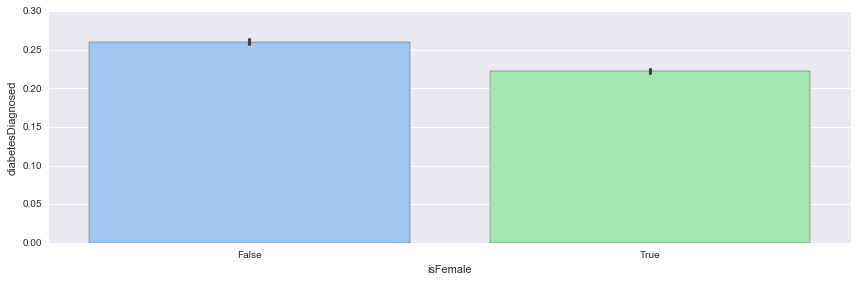

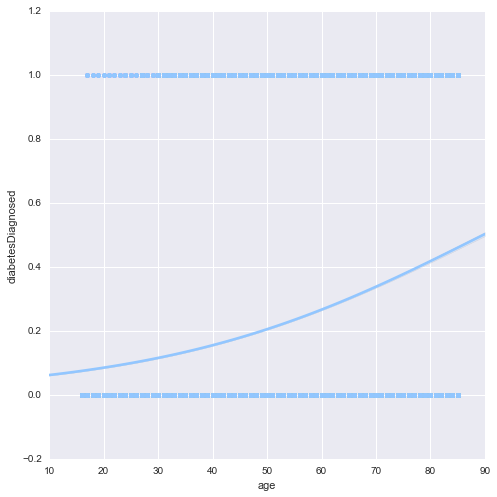

In [252]:
%matplotlib inline

plt.figure(figsize=(8,4))

# let's see if our other fields have any useful info...
sns.factorplot('isFemale','diabetesDiagnosed', data=diabetes_df, size=4, aspect=3, kind="bar")

# below regression takes around ten years to run - feel free to comment out this code
# it just shows diabetes incidence increases pretty dramatically with age
sns.lmplot(x='age', y='diabetesDiagnosed', data=diabetes_df, size=7, logistic=True)

I'm going to be using simple modeling algorithms that don't tend to overfit, so I'll just split into train and test rather than train, cross-validation, and test. If I were e.g. doing gradient-boosting, I'd also create a cross-validation set.

In [253]:
# for now, drop our qualitative variables - obviously there's a tremendous amount of info
# in rxName, so we'll want to add it back later
dropped_qual = diabetes_df.drop(['rxName', 'rxForm'], axis=1)

# TODO: refactor train-test split into function; 
# we'll still need the variables as globals so we can refer to them outside the function.

# split training and test
X_train, X_test, Y_train, Y_test = train_test_split(dropped_qual.drop(
        ['diabetesDiagnosed'],axis=1), dropped_qual['diabetesDiagnosed'], test_size=.3, random_state=2016)

for dataset in [X_train, X_test, Y_train, Y_test]:
    print("\n\nDataset --> \n\n")
    print(dataset.head(5))
    



Dataset --> 


              id  age  rxStartYear  rxQuantity isFemale  \
32825   17445103   27       1995.0         8.5     True   
141300  83870101   59       2005.0         8.0    False   
53002   42718102   57       2004.0       270.0     True   
136758  82936101   29       2008.0        20.0     True   
111922  75138101   63       2007.0       240.0    False   

        d__Amer Indian/Alaska Native  d__Asian  d__Black  d__Multiple  \
32825                            0.0       0.0       0.0          0.0   
141300                           0.0       0.0       0.0          0.0   
53002                            0.0       0.0       0.0          0.0   
136758                           0.0       0.0       1.0          0.0   
111922                           0.0       0.0       0.0          0.0   

        d__Native Hawaiian/Pacific Islander  d__White  d__DIVORCED  \
32825                                   0.0       1.0          0.0   
141300                                  0.0      

In [254]:
# split training and test; of course, drop our y-var and our ID from our x 
X_train, X_test, Y_train, Y_test = train_test_split(dropped_qual.drop(
        ['diabetesDiagnosed', 'id'],axis=1), dropped_qual['diabetesDiagnosed'], test_size=.3, random_state=2016)

for dataset in [X_train, X_test, Y_train, Y_test]:
    print("\n\nDataset --> \n\n")
    print(dataset.head(3))



Dataset --> 


        age  rxStartYear  rxQuantity isFemale  d__Amer Indian/Alaska Native  \
32825    27       1995.0         8.5     True                           0.0   
141300   59       2005.0         8.0    False                           0.0   
53002    57       2004.0       270.0     True                           0.0   

        d__Asian  d__Black  d__Multiple  d__Native Hawaiian/Pacific Islander  \
32825        0.0       0.0          0.0                                  0.0   
141300       0.0       0.0          0.0                                  0.0   
53002        0.0       0.0          0.0                                  0.0   

        d__White  d__DIVORCED  d__DIVORCED IN ROUND  d__MARRIED  \
32825        1.0          0.0                   0.0         0.0   
141300       1.0          0.0                   0.0         1.0   
53002        1.0          0.0                   0.0         1.0   

        d__MARRIED IN ROUND  d__NEVER MARRIED  d__SEPARATED  \
32825        

In [255]:
logistic = LogisticRegression(random_state=2016, solver='liblinear', n_jobs=-1)
logistic.fit(X_train, Y_train)
Y_pred = logistic.predict(X_test)

print(logistic.score(X_train, Y_train))
print(classification_report(Y_test, Y_pred, digits=3))

# flatten logistic regression coefficients to a list and show corresponding quantities
def print_coef_importances(importances, columns):
    coefficients = zip(columns, importances.flatten())
    sorted_coef = sorted(coefficients, key= lambda tup: abs(tup[1]), reverse=True)
    print(sorted_coef)

print_coef_importances(logistic.coef_, X_train.columns)

0.75933292405
             precision    recall  f1-score   support

      False      0.766     0.988     0.863     38940
       True      0.379     0.024     0.045     12021

avg / total      0.675     0.761     0.670     50961

[('d__White', -0.31663207901636947), ('d__Black', 0.28534401848537128), ('d__NEVER MARRIED', -0.19071907200723845), ('isFemale', -0.18567683346563954), ('d__DIVORCED', 0.1015864946778004), ('d__SEPARATED', 0.099762367464286336), ('d__WIDOWED', -0.091018264609931593), ('d__Asian', -0.086184226086257101), ('d__Amer Indian/Alaska Native', 0.075915702646738928), ('d__SEPARATED IN ROUND', 0.041119237379007322), ('d__WIDOWED IN ROUND', 0.03517500302837126), ('age', 0.033705633669340394), ('d__Multiple', 0.025321792120123414), ('d__Native Hawaiian/Pacific Islander', 0.020420937642327885), ('d__MARRIED IN ROUND', 0.0073780694558203061), ('rxStartYear', -0.0013625821103276749), ('d__MARRIED', 0.00067524504642572751), ('d__DIVORCED IN ROUND', 0.00022706535741318166), ('r

In [256]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=2016)
Y_pred = None
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
print(random_forest.score(X_test, Y_test))
print(classification_report(Y_test, Y_pred, digits=3))

0.798041639685
             precision    recall  f1-score   support

      False      0.840     0.909     0.873     38940
       True      0.598     0.440     0.507     12021

avg / total      0.783     0.798     0.787     50961



In [257]:
print_coef_importances(random_forest.feature_importances_, X_train.columns)

[('age', 0.4652385873122708), ('rxQuantity', 0.24423956849183173), ('rxStartYear', 0.19271670603240551), ('isFemale', 0.018871285868560104), ('d__NEVER MARRIED', 0.011402176981243805), ('d__White', 0.0085005850393422289), ('d__Black', 0.0082115158228942258), ('d__MARRIED', 0.0072181696981945829), ('d__WIDOWED', 0.0068713514130528779), ('d__DIVORCED', 0.0063310875454458152), ('d__DIVORCED IN ROUND', 0.0044343484406333868), ('d__SEPARATED', 0.0042436007920150605), ('d__Asian', 0.003618774186718091), ('d__SEPARATED IN ROUND', 0.0035599261904346487), ('d__MARRIED IN ROUND', 0.0033190631005893039), ('d__WIDOWED IN ROUND', 0.0031823276151904832), ('d__Amer Indian/Alaska Native', 0.0031534828616349066), ('d__Multiple', 0.0030204041290615965), ('d__Native Hawaiian/Pacific Islander', 0.0018670384784808408)]


I included a logistic regression here so we can inspect it for information. For example, it shows that ethnicity has a pretty significant impact on the probability of having diabetes. However, as a predictive model, it's not terribly impressive. In particular, its recall for the positive class is awful.

Our RF accuracy is around what we'd expect, given how little information it has. And it's using age correctly while also giving some weight to rxStartYear and rxQuantitiy. (I suspect some information about type of drug / administration method may be contained in the quantity.) 

It's not shocking that our recall is much better for False than True. That's just saying it's way easier to predict that someone doesn't have diabetes than that she does. Also, since False is around 3/4 of the dataset, our model's going to benefit more from assuming results will be False. 

We can tweak our decision threshold using predict_proba in the RF model, but I think that's beyond the scope of this exercise. But it would make sense to do so if we're looking to warn doctors of possible diabetes cases. (Also, we might just want to report probabilities if we can go ahead and assume the audience has a good understanding of probabilities.) (We can use AUC to get around the issue with False values being weighted heavily, but our class distribution actually isn't that skewed, so the advantage of AUC over accuracy isn't that substantial.)

The next order of business is to deal with the rxName column.

### Incorporating prescription names into our model

First, let's just try label encoding our prescriptions.

In [258]:
with_rx = diabetes_df.drop(['rxForm'], axis=1)

label_encoder = LabelEncoder()
with_rx['rxEnc'] = label_encoder.fit_transform(with_rx['rxName'])


X_train_enc, X_test_enc, Y_train_enc, Y_test_enc = train_test_split(with_rx.drop(
        ['diabetesDiagnosed', 'id', 'rxName'],axis=1), with_rx['diabetesDiagnosed'], test_size=.3, random_state=2016)

for dataset in [X_train_enc, X_test_enc, Y_train_enc, Y_test_enc]:
    print("\n\nDataset --> \n\n")
    print(dataset.head(4))



Dataset --> 


        age  rxStartYear  rxQuantity isFemale  d__Amer Indian/Alaska Native  \
32825    27       1995.0         8.5     True                           0.0   
141300   59       2005.0         8.0    False                           0.0   
53002    57       2004.0       270.0     True                           0.0   
136758   29       2008.0        20.0     True                           0.0   

        d__Asian  d__Black  d__Multiple  d__Native Hawaiian/Pacific Islander  \
32825        0.0       0.0          0.0                                  0.0   
141300       0.0       0.0          0.0                                  0.0   
53002        0.0       0.0          0.0                                  0.0   
136758       0.0       1.0          0.0                                  0.0   

        d__White  d__DIVORCED  d__DIVORCED IN ROUND  d__MARRIED  \
32825        1.0          0.0                   0.0         0.0   
141300       1.0          0.0                   0.0 

In [259]:
random_forest_enc = RandomForestClassifier(n_estimators=200, max_features=.25, random_state=2016)
random_forest_enc.fit(X_train_enc, Y_train_enc)
Y_pred_enc = random_forest_enc.predict(X_test_enc)
print(random_forest_enc.score(X_test_enc, Y_test_enc))
print(classification_report(Y_test_enc, Y_pred_enc, digits=3))
print_coef_importances(random_forest_enc.feature_importances_, X_train_enc)

0.815859186437
             precision    recall  f1-score   support

      False      0.839     0.940     0.886     38940
       True      0.680     0.415     0.515     12021

avg / total      0.801     0.816     0.799     50961

[('rxEnc', 0.35398435551171209), ('age', 0.27715322916652146), ('rxQuantity', 0.14090545116620132), ('rxStartYear', 0.12975271622537737), ('isFemale', 0.017484588518532452), ('d__NEVER MARRIED', 0.010288315716291612), ('d__MARRIED', 0.0096826769413478238), ('d__DIVORCED', 0.0080087786179136606), ('d__White', 0.0078837569052105805), ('d__Black', 0.0070321742027170883), ('d__WIDOWED', 0.0069372794663128522), ('d__DIVORCED IN ROUND', 0.0047733245400687994), ('d__SEPARATED', 0.0045532370441587824), ('d__Asian', 0.0037427872888634597), ('d__SEPARATED IN ROUND', 0.0036170264990872509), ('d__WIDOWED IN ROUND', 0.0035431486475533697), ('d__MARRIED IN ROUND', 0.0034689529285074662), ('d__Multiple', 0.0028735422941317647), ('d__Amer Indian/Alaska Native', 0.002745004031

Another approach is to one-hot encode. But here it gets a little messy and subjective. There are at least a few way to do this:  

1) pick the n most common drugs to use  
2) pick the n most common drugs in diabetes patients to use  
3) pick the n drugs that have the highest precision or recall when thought of as a "test" for diabetes  

I don't really think it's an option to encode every drug - we'd have literally thousands of columns.  
I'll start with (1) as the simplest solution, but there's certainly value to the others, and ideally we'd try them all.

In [260]:
# most common drugs overall
diabetes_df['rxName'].value_counts()[0:20]

AZITHROMYCIN                   3358
LISINOPRIL                     2865
AMOXICILLIN                    2687
SIMVASTATIN                    2312
IBUPROFEN                      2243
PREDNISONE                     1712
HYDROCO/APAP                   1703
LIPITOR                        1630
OMEPRAZOLE                     1496
METFORMIN                      1422
HYDROCHLOROTHIAZIDE            1281
NAPROXEN                       1198
ATENOLOL                       1102
FUROSEMIDE                     1082
LEVOTHYROXIN                    954
APAP/HYDROCODONE BITARTRATE     951
AMLODIPINE                      928
HYDROCHLOROT                    852
AMLODIPINE BESYLATE             832
NEXIUM                          829
Name: rxName, dtype: int64

In [261]:
# most common drugs for those with diabetes
# note that most of these aren't all that specific for diabetes - 
# people with type 2 diabetes are often overweight and have other health issues

have_diabetes = diabetes_df[diabetes_df['diabetesDiagnosed'] == True]
print(have_diabetes['rxName'].value_counts()[0:20])

METFORMIN                  1158
LISINOPRIL                  975
SIMVASTATIN                 701
LIPITOR                     518
ACTOS                       449
FUROSEMIDE                  447
GLIPIZIDE                   431
METFORMIN HCL               426
ONETOUCH                    366
LANTUS                      350
GLYBURIDE                   342
AZITHROMYCIN                328
OMEPRAZOLE                  315
HYDROCHLOROTHIAZIDE         300
METFORMIN HYDROCHLORIDE     288
GLIMEPIRIDE                 284
INSULIN SYRG                268
AMOXICILLIN                 250
ASPIRIN                     247
HYDROCO/APAP                245
Name: rxName, dtype: int64


In [262]:
# confirming that our label encoder worked correctly 

print(with_rx['rxName'].value_counts()[:10])
print(with_rx['rxEnc'].value_counts()[:10])

AZITHROMYCIN    3358
LISINOPRIL      2865
AMOXICILLIN     2687
SIMVASTATIN     2312
IBUPROFEN       2243
PREDNISONE      1712
HYDROCO/APAP    1703
LIPITOR         1630
OMEPRAZOLE      1496
METFORMIN       1422
Name: rxName, dtype: int64
817     3358
3923    2865
486     2687
6295    2312
3443    2243
5632    1712
3295    1703
3906    1630
5028    1496
4235    1422
Name: rxEnc, dtype: int64


#### Filtering prescriptions by frequency (so we can feed them into the model)

In [263]:
#reinitalize with_rx df so we can run various code nonsequentially 
with_rx = diabetes_df.drop(['rxForm'], axis=1)

filtered_rx = with_rx

filter_by_len = with_rx.groupby('rxName')['rxName'].filter(lambda x: len(x) >= 100)
common_drugs = set(filter_by_len)
filtered_rx['rxName'] = [rxName if rxName in common_drugs else 'OTHER' for rxName in filtered_rx['rxName']]

print(filtered_rx.rxName.head(20))
print(filtered_rx.shape)
print(with_rx.shape)
print('ATENOLOL' in common_drugs)
print('this is not there' in common_drugs)

0         ATENOLOL
1     AZITHROMYCIN
2            OTHER
3     HYDROCO/APAP
4     CARISOPRODOL
5            OTHER
6            OTHER
7            OTHER
8          NORVASC
9         SEROQUEL
10       CLONIDINE
11       COMBIVENT
12         DIGOXIN
13       LORAZEPAM
14     SIMVASTATIN
15    HYDROCHLOROT
16      CARVEDILOL
17         LIPITOR
18           OTHER
19           OTHER
Name: rxName, dtype: object
(169868, 22)
(169868, 22)
True
False


Great, so we have all rx with frequency >=100. Now we have to re-encode to labels and then one-hot encode. If we didn't re-encode, our one-hot encoder would still be based on the entire list of rx's, and we'd have an inordinate number of columns.

In [264]:
label_encoder = LabelEncoder()
try_drop(filtered_rx, ['rxEnc'])
filtered_rx['rxEnc'] = label_encoder.fit_transform(filtered_rx['rxName'])

print(filtered_rx['rxName'].head(10))
print(filtered_rx['rxEnc'].head(10))

print("\n\n We'll have to add columns = ")
print(filtered_rx.rxEnc.max())

Drop failed on column (probably already dropped): rxEnc
0        ATENOLOL
1    AZITHROMYCIN
2           OTHER
3    HYDROCO/APAP
4    CARISOPRODOL
5           OTHER
6           OTHER
7           OTHER
8         NORVASC
9        SEROQUEL
Name: rxName, dtype: object
0     37
1     43
2    220
3    138
4     56
5    220
6    220
7    220
8    213
9    263
Name: rxEnc, dtype: int64


 We'll have to add columns = 
329


Great, our others are correctly encoded and our maxencoding seems reasonable.

Now it's time for

### One-hot encoding

In [265]:
rx_ohe = filtered_rx

# we'll just use the dummies feature in pd
onehot_df = pd.get_dummies(filtered_rx.rxEnc)

print(onehot_df[0].describe())

count    169868.000000
mean          0.001189
std           0.034464
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: 0, dtype: float64


Above columns are about 99.9% sparse! We might want to encode them as a sparse matrix.

In [266]:
# get cols back into the data frame
rx_ohe = pd.concat([filtered_rx, onehot_df], axis=1)

rx_ohe.columns

Index([                          u'id',                          u'age',
                  u'diabetesDiagnosed',                  u'rxStartYear',
                             u'rxName',                   u'rxQuantity',
                           u'isFemale', u'd__Amer Indian/Alaska Native',
                           u'd__Asian',                     u'd__Black',
       ...
                                   320,                             321,
                                   322,                             323,
                                   324,                             325,
                                   326,                             327,
                                   328,                             329],
      dtype='object', length=353)

In [267]:
# split training and test, again
X_train_ohe, X_test_ohe, Y_train_ohe, Y_test_ohe = train_test_split(rx_ohe.drop(
        ['diabetesDiagnosed', 'id', 'rxName'],axis=1), rx_ohe['diabetesDiagnosed'], test_size=.3, random_state=2016)

In [269]:
random_forest_ohe = RandomForestClassifier(n_estimators=300, max_features=100, random_state=2016)
random_forest_ohe.fit(X_train_ohe, Y_train_ohe)
Y_pred_ohe = random_forest_ohe.predict(X_test_ohe)
print(random_forest_ohe.score(X_test_ohe, Y_test_ohe))
print(classification_report(Y_test_ohe, Y_pred_ohe, digits=3))

0.810933851377
             precision    recall  f1-score   support

      False      0.836     0.936     0.883     38940
       True      0.662     0.405     0.502     12021

avg / total      0.795     0.811     0.793     50961



In [272]:
logistic_ohe = LogisticRegression(random_state=2016, solver='liblinear', n_jobs=-1)
logistic_ohe.fit(X_train_ohe, Y_train_ohe)
Y_pred_ohe = logistic_ohe.predict(X_test_ohe)

print(logistic_ohe.score(X_test_ohe, Y_test_ohe))
print(classification_report(Y_test_ohe, Y_pred_ohe, digits=3))

0.765036007928
             precision    recall  f1-score   support

      False      0.768     0.991     0.866     38940
       True      0.532     0.032     0.061     12021

avg / total      0.713     0.765     0.676     50961



In this case, RF was able to exploit the encodings effectively, so one-hot encoding wasn't terribly useful.

#### Fixing our class weight problem

In [273]:
random_forest_bal = RandomForestClassifier(n_estimators=200, random_state=2016, class_weight="balanced")
random_forest_bal.fit(X_train_enc, Y_train_enc)
Y_pred_bal = random_forest_bal.predict(X_test_enc)
print(random_forest_bal.score(X_test_enc, Y_test_enc))
print(classification_report(Y_test_enc, Y_pred_bal, digits=3))

0.812896136261
             precision    recall  f1-score   support

      False      0.835     0.941     0.885     38940
       True      0.675     0.398     0.501     12021

avg / total      0.797     0.813     0.794     50961



By weighting our classes inverse to their frequency, we marginally improved performance. Of course, it would be wise to plot AUC and tweak our decision threshold.

### Bonus 

### XGBoost

In [274]:
%%capture

xgboost = xgb.XGBClassifier(missing=np.nan, max_depth=5, n_estimators=3000, learning_rate=0.02, silent=True, 
                            nthread=-1, subsample=0.90, colsample_bytree=0.90, seed=2016)

# cross-validation on the test set is a little bit questionable; 
# in the real world, you'd probably want train/cv/test or k-fold validation
xgboost.fit(X_train_enc, Y_train_enc, early_stopping_rounds=10,
            eval_metric="auc", eval_set=[(X_test_enc, Y_test_enc)])




XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0, learning_rate=0.02, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=3000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=2016, silent=True, subsample=0.9)

In [275]:
predicted_probs = xgboost.predict_proba(X_test_enc)[:,1]

print('Overall AUC on test:', roc_auc_score(Y_test_enc, predicted_probs))
Y_pred_enc = xgboost.predict(X_test_enc)
xgb_accuracy = xgboost.score(X_test_enc, Y_test_enc)
print(xgb_accuracy)
print(classification_report(Y_test_enc, Y_pred_enc, digits=3))
      


('Overall AUC on test:', 0.8196894766037538)
0.827495535802
             precision    recall  f1-score   support

      False      0.826     0.981     0.897     38940
       True      0.844     0.330     0.474     12021

avg / total      0.830     0.827     0.797     50961



So we got an extra 1% accuracy from xgboost vs. rf (.816 vs .827). We lost some recall for the true cases.

### Tweaking the decision threshold

We wanted to be able to correctly recall instances of diabetes - so here we'll tweak the decision threshold up to trade precision for recall (and, specifically, recall for the positive cases).

We'll graph AUC to get a better idea of the trade-offs involved.

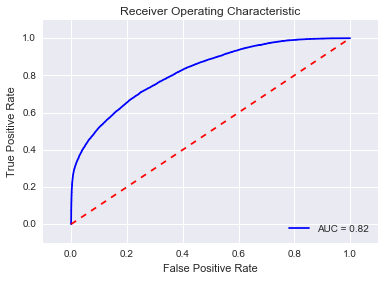

In [276]:
#from @motuai10
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test_enc, predicted_probs)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [278]:
Y_pred_30 = predicted_probs >= .30
print(classification_report(Y_test_enc, Y_pred_30, digits=3))

             precision    recall  f1-score   support

      False      0.869     0.856     0.862     38940
       True      0.555     0.582     0.568     12021

avg / total      0.795     0.791     0.793     50961

